In [1]:
using Mocha

Configuring Mocha...
 * CUDA       disabled by default
 * Native Ext disabled by default
Mocha configured, continue loading module...
DefaultBackend = Mocha.CPUBackend


In [2]:
data_layer  = HDF5DataLayer(name="train-data", source="data/train.txt",
    batch_size=64, shuffle=true)

Mocha.HDF5DataLayer(train-data)

In [3]:
conv_layer = ConvolutionLayer(name="conv1", n_filter=20, kernel=(5,5),
    bottoms=[:data], tops=[:conv1])

Mocha.ConvolutionLayer(conv1)

In [4]:
pool_layer = PoolingLayer(name="pool1", kernel=(2,2), stride=(2,2),
    bottoms=[:conv1], tops=[:pool1])
conv2_layer = ConvolutionLayer(name="conv2", n_filter=50, kernel=(5,5),
    bottoms=[:pool1], tops=[:conv2])
pool2_layer = PoolingLayer(name="pool2", kernel=(2,2), stride=(2,2),
    bottoms=[:conv2], tops=[:pool2])


Mocha.PoolingLayer(pool2)

In [5]:
fc1_layer  = InnerProductLayer(name="ip1", output_dim=500,
    neuron=Neurons.ReLU(), bottoms=[:pool2], tops=[:ip1])
fc2_layer  = InnerProductLayer(name="ip2", output_dim=10,
    bottoms=[:ip1], tops=[:ip2])

Mocha.InnerProductLayer(ip2)

In [6]:
loss_layer = SoftmaxLossLayer(name="loss", bottoms=[:ip2,:label])

Mocha.SoftmaxLossLayer(loss)

In [7]:
backend = CPUBackend()
init(backend)

In [8]:
common_layers = [conv_layer, pool_layer, conv2_layer, pool2_layer,
    fc1_layer, fc2_layer]
net = Net("MNIST-train", backend, [data_layer, common_layers..., loss_layer])

[2018-10-14T23:13:09 | info | Mocha]: Constructing net MNIST-train on Mocha.CPUBackend...
[2018-10-14T23:13:09 | info | Mocha]: Topological sorting 8 layers...
[2018-10-14T23:13:09 | info | Mocha]: Setup layers...
[2018-10-14T23:13:13 | info | Mocha]: Network constructed!


************************************************************
          NAME: MNIST-train
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.HDF5DataLayer(train-data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 64)
         label: Blob(1 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 64)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 64)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 64)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 64)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
    

In [9]:
exp_dir = "snapshots"
method = SGD()
params = make_solver_parameters(method, max_iter=10000, regu_coef=0.0005,
    mom_policy=MomPolicy.Fixed(0.9),
    lr_policy=LRPolicy.Inv(0.01, 0.0001, 0.75),
    load_from=exp_dir)
solver = Solver(method, params)

Mocha.Solver{Mocha.SGD}(Mocha.SGD(), Dict{Symbol,Any}(Pair{Symbol,Any}(:lr_policy, Mocha.LRPolicy.Inv(0.01, 0.0001, 0.75)),Pair{Symbol,Any}(:max_iter, 10000),Pair{Symbol,Any}(:load_from, "snapshots"),Pair{Symbol,Any}(:regu_coef, 0.0005),Pair{Symbol,Any}(:mom_policy, Mocha.MomPolicy.Fixed(0.9))), Mocha.CoffeeLounge("", 1, :merge, Dict{AbstractString,Dict{Int64,AbstractFloat}}(), Mocha.CoffeeBreak[], false, 0, 0))

In [10]:
setup_coffee_lounge(solver, save_into="$exp_dir/statistics.jld", every_n_iter=1000)


:merge

In [11]:
add_coffee_break(solver, TrainingSummary(), every_n_iter=100)

1-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)

In [12]:
add_coffee_break(solver, Snapshot(exp_dir), every_n_iter=5000)


2-element Array{Mocha.CoffeeBreak,1}:
 Mocha.CoffeeBreak(Mocha.TrainingSummary(Any[:iter, :obj_val]), 100, 0)
 Mocha.CoffeeBreak(Mocha.Snapshot("snapshots"), 5000, 0)               

In [13]:
data_layer_test = HDF5DataLayer(name="test-data", source="data/test.txt", batch_size=100)
acc_layer = AccuracyLayer(name="test-accuracy", bottoms=[:ip2, :label])
test_net = Net("MNIST-test", backend, [data_layer_test, common_layers..., acc_layer])

[2018-10-14T23:14:02 | info | Mocha]: Constructing net MNIST-test on Mocha.CPUBackend...
[2018-10-14T23:14:02 | info | Mocha]: Topological sorting 8 layers...
[2018-10-14T23:14:02 | info | Mocha]: Setup layers...
[2018-10-14T23:14:02 | info | Mocha]: Network constructed!


************************************************************
          NAME: MNIST-test
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.HDF5DataLayer(test-data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 100)
         label: Blob(1 x 100)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 100)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 100)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 100)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 100)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------


In [15]:
add_coffee_break(solver, ValidationPerformance(test_net), every_n_iter=1000);

In [16]:
solve(solver, net)

destroy(net)
destroy(test_net)
shutdown(backend)

[2018-10-14T23:14:36 | info | Mocha]: Snapshot directory snapshots already exists
[2018-10-14T23:14:36 | info | Mocha]:  TRAIN iter=000000 obj_val=2.35343313
[2018-10-14T23:14:37 | info | Mocha]: Saving snapshot to snapshot-000000.jld...
[2018-10-14T23:15:30 | info | Mocha]: 
[2018-10-14T23:15:30 | info | Mocha]: ## Performance on Validation Set after 0 iterations
[2018-10-14T23:15:30 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:15:30 | info | Mocha]:   Accuracy (avg over 10000) = 10.0500%
[2018-10-14T23:15:30 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:15:30 | info | Mocha]: 
[2018-10-14T23:16:13 | info | Mocha]: 
[2018-10-14T23:16:13 | info | Mocha]: ## Performance on Validation Set after 0 iterations
[2018-10-14T23:16:13 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:16:13 | info | Mocha]:   Accuracy (avg over 10000) = 10.0500%
[2018-10-14T23:16:13 | 

[2018-10-14T23:46:10 | info | Mocha]:  TRAIN iter=004800 obj_val=0.00339105
[2018-10-14T23:46:41 | info | Mocha]:  TRAIN iter=004900 obj_val=0.01310998
[2018-10-14T23:47:15 | info | Mocha]:  TRAIN iter=005000 obj_val=0.04089012
[2018-10-14T23:47:15 | info | Mocha]: Saving snapshot to snapshot-005000.jld...
[2018-10-14T23:47:55 | info | Mocha]: 
[2018-10-14T23:47:55 | info | Mocha]: ## Performance on Validation Set after 5000 iterations
[2018-10-14T23:47:55 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:47:55 | info | Mocha]:   Accuracy (avg over 10000) = 98.9800%
[2018-10-14T23:47:55 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:47:55 | info | Mocha]: 
[2018-10-14T23:48:36 | info | Mocha]: 
[2018-10-14T23:48:36 | info | Mocha]: ## Performance on Validation Set after 5000 iterations
[2018-10-14T23:48:36 | info | Mocha]: ---------------------------------------------------------
[2018-10-14T23:48:36 | i

[2018-10-15T00:16:58 | info | Mocha]:  TRAIN iter=009700 obj_val=0.00723958
[2018-10-15T00:17:28 | info | Mocha]:  TRAIN iter=009800 obj_val=0.00103207
[2018-10-15T00:17:58 | info | Mocha]:  TRAIN iter=009900 obj_val=0.00577148
[2018-10-15T00:18:28 | info | Mocha]:  TRAIN iter=010000 obj_val=0.02374324
[2018-10-15T00:18:28 | info | Mocha]: Saving snapshot to snapshot-010000.jld...
[2018-10-15T00:19:07 | info | Mocha]: 
[2018-10-15T00:19:07 | info | Mocha]: ## Performance on Validation Set after 10000 iterations
[2018-10-15T00:19:07 | info | Mocha]: ---------------------------------------------------------
[2018-10-15T00:19:07 | info | Mocha]:   Accuracy (avg over 10000) = 99.0800%
[2018-10-15T00:19:07 | info | Mocha]: ---------------------------------------------------------
[2018-10-15T00:19:07 | info | Mocha]: 
[2018-10-15T00:19:46 | info | Mocha]: 
[2018-10-15T00:19:46 | info | Mocha]: ## Performance on Validation Set after 10000 iterations
[2018-10-15T00:19:46 | info | Mocha]: ----

Dict{AbstractString,Array{Mocha.AbstractParameter,1}} with 0 entries

In [17]:
backend = CPUBackend()
init(backend)

mem_data = MemoryDataLayer(name="data", tops=[:data], batch_size=1,
    data=Array[zeros(Float32, 28, 28, 1, 1)])
softmax_layer = SoftmaxLayer(name="prob", tops=[:prob], bottoms=[:ip2])

# define common_layers as earlier

run_net = Net("imagenet", backend, [mem_data, common_layers..., softmax_layer])

[2018-10-15T00:20:45 | info | Mocha]: Constructing net imagenet on Mocha.CPUBackend...
[2018-10-15T00:20:45 | info | Mocha]: Topological sorting 8 layers...
[2018-10-15T00:20:45 | info | Mocha]: Setup layers...
[2018-10-15T00:20:45 | info | Mocha]: Network constructed!


************************************************************
          NAME: imagenet
       BACKEND: Mocha.CPUBackend
  ARCHITECTURE: 8 layers
............................................................
 *** Mocha.MemoryDataLayer(data)
    Outputs ---------------------------
          data: Blob(28 x 28 x 1 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv1)
    Inputs ----------------------------
          data: Blob(28 x 28 x 1 x 1)
    Outputs ---------------------------
         conv1: Blob(24 x 24 x 20 x 1)
............................................................
 *** Mocha.PoolingLayer(pool1)
    Inputs ----------------------------
         conv1: Blob(24 x 24 x 20 x 1)
    Outputs ---------------------------
         pool1: Blob(12 x 12 x 20 x 1)
............................................................
 *** Mocha.ConvolutionLayer(conv2)
    Inputs ----------------------------
         pool1: Blob(12 x 12 x 20 x 1)
    Ou

In [18]:
load_snapshot(run_net, "snapshots/snapshot-010000.jld")

[2018-10-15T00:21:01 | info | Mocha]: Loading existing model from snapshots/snapshot-010000.jld


Mocha.SolverState{Mocha.SGDSolverState}(10000, 0.023743240162730217, Dict{Any,Any}(), Mocha.SGDSolverState(0.005946035575013605, 0.9, Mocha.LayerState[Mocha.ConvolutionLayerState(Mocha.ConvolutionLayer(conv1), Mocha.Blob[Blob(24 x 24 x 20 x 1)], Mocha.Blob[Blob(24 x 24 x 20 x 1)], Mocha.Parameter[Mocha.Parameter("filter", Blob(5 x 5 x 1 x 20), Blob(5 x 5 x 1 x 20), Mocha.NullInitializer(), Mocha.L2Regu(1.0), Mocha.NoCons(0.0, 0), 1.0, Mocha.RefCounter(2)), Mocha.Parameter("bias", Blob(20), Blob(20), Mocha.NullInitializer(), Mocha.NoRegu(0.0), Mocha.NoCons(0.0, 0), 2.0, Mocha.RefCounter(2))], Blob(5 x 5 x 1 x 20), Blob(5 x 5 x 1 x 20), Blob(20), Blob(20), 24, 24, Mocha.CPUConvState(Blob(24 x 24 x 25 x 1), 576, 20, 25, Blob(576 x 1 x 1 x 1), Float32[0.0 0.00615451 … 0.0 NaN32; 0.0 4.58155f-41 … 0.0 NaN32; … ; 0.00615356 0.00615487 … 0.0 1.4013f-45; 4.58155f-41 4.58155f-41 … 0.0 0.0]), false), Mocha.ConvolutionLayerState(Mocha.ConvolutionLayer(conv2), Mocha.Blob[Blob(8 x 8 x 50 x 1)], Moc

In [19]:
using HDF5
h5open("data/test.hdf5") do f
    get_layer(run_net, "data").data[1][:,:,1,1] = f["data"][:,:,1,1]
    println("Correct label index: ", Int64(f["label"][:,1][1]+1))
end

forward(run_net)
println()
println("Label probability vector:")
println(run_net.output_blobs[:prob].data)

Correct label index: 9

Label probability vector:
Float32[3.2036f-9; 5.68322f-10; 2.88924f-8; 8.68315f-8; 2.07834f-10; 1.4505f-5; 3.30415f-8; 6.85175f-8; 0.999985; 2.2187f-8]


In [20]:
using PyPlot, JLD

INFO: Recompiling stale cache file /Users/maxwellhostetter/.julia/lib/v0.6/PyPlot.ji for module PyPlot.


In [21]:
stats = load("snapshots/statistics.jld")
# println(typeof(stats))

tables = stats["statistics"]
ov = tables["obj_val"]
xy = sort(collect(ov))
x = [i for (i,j) in xy]
y = [j for (i,j) in xy]
x = convert(Array{Int64}, x)
y = convert(Array{Float64}, y)

101-element Array{Float64,1}:
 2.35343   
 0.351369  
 0.291655  
 0.170589  
 0.0639658 
 0.0632245 
 0.184028  
 0.0121269 
 0.131185  
 0.0415967 
 0.0588124 
 0.0937439 
 0.0355853 
 ⋮         
 0.0260526 
 0.0122025 
 0.00267477
 0.00230241
 0.0405073 
 0.00552822
 0.0132515 
 0.00692962
 0.00723958
 0.00103207
 0.00577148
 0.0237432 

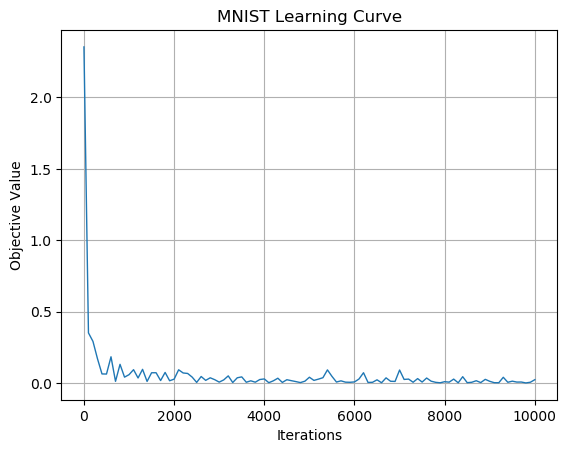

In [22]:
raw = plot(x, y, linewidth=1, label="Raw")
xlabel("Iterations")
ylabel("Objective Value")
title("MNIST Learning Curve")
grid("on")

In [23]:
method = SGD()

Mocha.SGD()

In [24]:
function low_pass{T <: Real}(x::Vector{T}, window::Int)
    len = length(x)
    y = Vector{Float64}(len)
    for i in 1:len
        # I want the mean of the first i terms up to width of window
        # Putting some numbers to this with window 4
        # i win lo  hi
        # 1  4  1   1
        # 2  4  1   2
        # 3  4  1   3
        # 4  4  1   4
        # 5  4  1   5
        # 6  4  2   6  => window starts to slide
        lo = max(1, i - window)
        hi = i
        y[i] = mean(x[lo:hi])
    end
    return y
end

low_pass (generic function with 1 method)

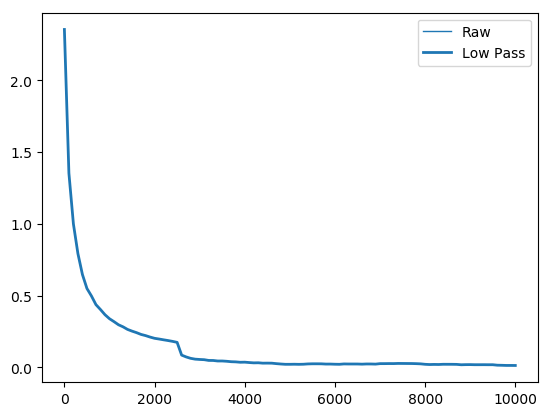

In [25]:
window = Int64(round(length(xy)/4.0))
y_avg = low_pass(y, window)
avg = plot(x, y_avg, linewidth=2, label="Low Pass")
legend(handles=[raw; avg])
show()  #required to display the figure in non-interactive mode